# Question 2: “What health indicators are considered most important for disease prediction?’’

## Importing Python libraries and the Initial Dataset

### Importing Python libraries

In [ ]:
#%pip install pandas mlxtend matplotlib seaborn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, fbeta_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns


### Importing the cleaned dataset from desktop folder

In [2]:
def read_csv_file(file_path):
    """
    Read a CSV file into a pandas DataFrame.

    Parameters:
    file_path (str): The path to the CSV file.

    Returns:
    pandas.DataFrame: The DataFrame containing the data from the CSV file.
    """
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)

    return df

# Specify the file path
file_path = 'C:/Users/steph/OneDrive/Desktop/Diabetes/archive/diabetes_012_health_indicators_BRFSS2015_cleaned.csv'

# Read the CSV file into a pandas DataFrame
df = read_csv_file(file_path)

# Display the DataFrame
display(df.head())

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,1,1,1,40.0,1,0,0,0,0,...,1,0,5,18,15,1,0,9,4,3
1,0,0,0,0,25.0,1,0,0,1,0,...,0,1,3,0,0,0,0,7,6,1
2,0,1,1,1,28.0,0,0,0,0,1,...,1,1,5,30,30,1,0,9,4,8
3,0,1,0,1,27.0,0,0,0,1,1,...,1,0,2,0,0,0,0,11,3,6
4,0,1,1,1,24.0,0,0,0,1,1,...,1,0,2,3,0,0,0,11,5,4


## Prepare Data for Feature Selection

### Check Data Types and Convert to Appropriate Type

In [3]:
#list column names and data type
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          253680 non-null  int64  
 1   HighBP                253680 non-null  int64  
 2   HighChol              253680 non-null  int64  
 3   CholCheck             253680 non-null  int64  
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  int64  
 6   Stroke                253680 non-null  int64  
 7   HeartDiseaseorAttack  253680 non-null  int64  
 8   PhysActivity          253680 non-null  int64  
 9   Fruits                253680 non-null  int64  
 10  Veggies               253680 non-null  int64  
 11  HvyAlcoholConsump     253680 non-null  int64  
 12  AnyHealthcare         253680 non-null  int64  
 13  NoDocbcCost           253680 non-null  int64  
 14  GenHlth               253680 non-null  int64  
 15  

In [4]:
#Convert data to appropriate types

#Define nominal YES/NO columns to convert to category type
nominal_columns = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk']
#Convert nominal columns to category type
# Convert each nominal column to categorical type
for column in nominal_columns:
    df[column] = pd.Categorical(df[column], 
                                 categories=[0, 1], 
                                 ordered=False)

#Define FEMALE/MALE categories and labels and convert to category type
df['Sex'] = pd.Categorical(df['Sex'], 
    categories=[0,1], 
    ordered=False
)

#Define discrete columns to convert to integer type
discrete_columns = ['MentHlth', 'PhysHlth']
#Convert discrete columns to integer type
df[discrete_columns] = df[discrete_columns].astype('int')

# Define ordinal categories with labels and convert to category type
df['Diabetes_012'] = pd.Categorical(df['Diabetes_012'], 
    categories=[0, 1, 2], 
    ordered=True
)

df['GenHlth'] = pd.Categorical(df['GenHlth'], 
    categories=[1, 2, 3, 4, 5], 
    ordered=True
)

df['Age'] = pd.Categorical(df['Age'], 
    categories=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], 
    ordered=True
)

df['Education'] = pd.Categorical(df['Education'], 
    categories=[1, 2, 3, 4, 5, 6], 
    ordered=True
)

df['Income'] = pd.Categorical(df['Income'], 
    categories=[1, 2, 3, 4, 5, 6, 7, 8], 
    ordered=True
)
#Dividing BMI into 6 categories based on CDC guidelines: https://www.cdc.gov/bmi/adult-calculator/bmi-categories.html
#Where 1 = 'Underweight', 2= 'Healthy weight', 3= 'Overweight', 4= 'Class 1 Obesity', 5 = 'Class 2 Obesity', 6 = 'Class 3 Obesity'])
df['BMI'] = pd.cut(df['BMI'], bins=[0, 18.4, 24.9, 29.9, 34.9, 39.9, 100], labels=[1, 2, 3, 4, 5, 6])

# Dividing MentHlth into 7 categories where the first category is for containing 0 only and the last category goes up to 30
# Where 0 = '0', 1 = '1-5', 2 ='6-10', 3 = '11-15', 4 = '16-20', 5 = '21-25', 6 = '26-30']
df['MentHlth'] = pd.cut(df['MentHlth'], bins=[-1, 0, 5, 10, 15, 20, 25, 30], labels=[0, 1, 2, 3, 4, 5, 6])

#Dividing PhysHlth into 7 categories where the first category is for containing 0 only and the last category goes up to 30
# Where 0 = '0', 1 = '1-5', 2 ='6-10', 3 = '11-15', 4 = '16-20', 5 = '21-25', 6 = '26-30']
df['PhysHlth'] = pd.cut(df['PhysHlth'], bins=[-1, 0, 5, 10, 15, 20, 25, 30], labels=[0, 1, 2, 3, 4, 5, 6])


In [5]:
#check data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   Diabetes_012          253680 non-null  category
 1   HighBP                253680 non-null  category
 2   HighChol              253680 non-null  category
 3   CholCheck             253680 non-null  category
 4   BMI                   253680 non-null  category
 5   Smoker                253680 non-null  category
 6   Stroke                253680 non-null  category
 7   HeartDiseaseorAttack  253680 non-null  category
 8   PhysActivity          253680 non-null  category
 9   Fruits                253680 non-null  category
 10  Veggies               253680 non-null  category
 11  HvyAlcoholConsump     253680 non-null  category
 12  AnyHealthcare         253680 non-null  category
 13  NoDocbcCost           253680 non-null  category
 14  GenHlth               253680 non-nul

### Identify and Drop Duplicate Values

In [6]:
#Identify duplicate values
duplicate = df.duplicated()
print(duplicate.sum())

51061


In [7]:
#Drop duplicat values
df = df.drop_duplicates()
print(df.shape)

(202619, 22)


In [8]:
#Check for duplicate values
duplicate = df.duplicated()
print(duplicate.sum())

0


## Split Data into Train and Test sets

In [9]:
#Split the data into train and test set where Diabetes_012 is the target variable
X = df.drop('Diabetes_012', axis=1)
y = df['Diabetes_012']

#Split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Check the shape of the train and test set
print(X_train.shape, X_test.shape)

(162095, 21) (40524, 21)


In [10]:
#Check the shape of the target variable in the train set
y_train.value_counts()


Diabetes_012
0    131150
2     27328
1      3617
Name: count, dtype: int64

## Balance the Train Set using SMOTE (Synthetic Minority Over-sampling Technique) 
The severe class imbalance can lead to biased and misleading performance metrics when checking for validity and generalizability of on the test set. The class imbalance also also affects feature selection on models that rely on the variability of the data. Using SMOTE creates synthetic samples rather than duplicating existing samples. 

In [11]:
#Oversample the minority class using SMOTE technique on the X_train and y_train data
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

#Check the shape of the target variable in the train set
y_train.value_counts()

Diabetes_012
0    131150
1    131150
2    131150
Name: count, dtype: int64

#### There are no continuous variables for us to standardize because all columns are categorical except for MentHlth and PhysHlth which are discrete variables.


## Initiate K-fold Cross-Validation and Train Feature Selection Techniques on Each Fold
Using stratified k fold helps ensure that validation set in each fold still reflects the balanced class distribution. Here, I selectected k = 5 because the dataset is already quite large. Chis square, Decision Tree, and Multinomial Logistic Regression models are trained on each fold of the train set.

In [63]:
# Initialize StratifiedKFold (use stratified to ensure each fold has a similar class distribution)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize metrics collection
chi_results = []
dt_results = []
lr_results = []


# Initialize lists to collect Chi-Square values and p-values for each fold
chi2_values_all = []
p_values_all = []

# Initialise lists to store metrics across fields
accuracies_dt = []
f1_scores_dt = []
f2_scores_dt = []
precisions_dt = []
recalls_dt = []
confusion_matrices_dt = []

accuracies_lr = []
f1_scores_lr = []
f2_scores_lr = []
precisions_lr = []
recalls_lr = []
confusion_matrices_lr = []

# Loop over each fold
for train_idx, val_idx in kf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # 1. Apply Chi-Square
    # Initialize SelectKBest with Chi-Square test
    chi2_selector = SelectKBest(chi2, k=10)
    chi2_selector.fit(X_train_fold, y_train_fold)

    # Get the p-values and chi-squared values
    chi2_values = chi2_selector.scores_
    p_values = chi2_selector.pvalues_

    # Transform the training set based on the feature selection
    X_train_chi2 = chi2_selector.transform(X_train_fold)
    X_val_chi2 = chi2_selector.transform(X_val_fold)

    # Initialize a Decision Tree model
    chi2_model = DecisionTreeClassifier(random_state=42)
    chi2_model.fit(X_train_chi2, y_train_fold)
    chi2_y_pred = chi2_model.predict(X_val_chi2)

    # Store metrics for Chi2
    accuracies_chi = accuracy_score(y_val_fold, chi2_y_pred)
    class_report_chi = classification_report(y_val_fold, chi2_y_pred, output_dict=True)
    precisions_chi = class_report_chi['macro avg']['precision']
    recalls_chi = class_report_chi['macro avg']['recall']
    f1_scores_chi = class_report_chi['macro avg']['f1-score']
    f2_scores_chi = fbeta_score(y_val_fold, chi2_y_pred, beta=2, average='macro')
    #precision, recall and f1 score for diabetes_012 = 2
    precisions_diabetes_012_2_chi = class_report_chi['2']['precision']
    recalls_diabetes_012_2_chi = class_report_chi['2']['recall']
    f1_scores_diabetes_012_2_chi = class_report_chi['2']['f1-score']
   

    confusion_matrices_chi = confusion_matrix(y_val_fold, chi2_y_pred)

    # Get chi2 values and p-values
    chi2_values = chi2_selector.scores_
    p_values = chi2_selector.pvalues_
    chi2_values_all.append(chi2_values)
    p_values_all.append(p_values)


    # Store the p-values and chi-squared values
    chi2_values_all.append(chi2_values)
    p_values_all.append(p_values)

    # Store the top 10 features
    chi2_features = X_train_fold.columns[chi2_selector.get_support()]
    chi_results.append(chi2_features)

    # 2. Apply Decision Tree
    dt_model = DecisionTreeClassifier(random_state=42)
    dt_model.fit(X_train_fold, y_train_fold)
    dt_pred = dt_model.predict(X_val_fold)

    #Store the to 10 features
    dt_features = dt_model.feature_importances_
    dt_results.append(dt_features)
    
    # Store metrics for Decision Tree
    accuracies_dt.append(accuracy_score(y_val_fold, dt_pred))
    class_report_dt = classification_report(y_val_fold, dt_pred, output_dict=True)
    precisions_dt.append(class_report_dt['macro avg']['precision'])
    recalls_dt.append(class_report_dt['macro avg']['recall'])
    f1_scores_dt.append(class_report_dt['macro avg']['f1-score'])
    f2_scores_dt = fbeta_score(y_val_fold, dt_pred, beta=2, average='macro')
    #precision, recall and f1 score for diabetes_012 = 2
    precisions_diabetes_012_2_dt = class_report_dt['2']['precision']
    recalls_diabetes_012_2_dt = class_report_dt['2']['recall']
    f1_scores_diabetes_012_2_dt = class_report_dt['2']['f1-score']

    confusion_matrices_dt.append(confusion_matrix(y_val_fold, dt_pred))
    
    # 3. Apply Multinomial Logistic Regression
    lr_model = LogisticRegression(multi_class='multinomial', penalty='l2', C=1.0, solver='lbfgs', max_iter=1000, random_state = 42)
    lr_model.fit(X_train_fold, y_train_fold)
    lr_pred = lr_model.predict(X_val_fold)

    #Store the top 10 features
    lr_features = lr_model.coef_
    lr_results.append(lr_features)
    
    # Store metrics for Logistic Regression
    accuracies_lr.append(accuracy_score(y_val_fold, lr_pred))
    class_report_lr = classification_report(y_val_fold, lr_pred, output_dict=True)
    precisions_lr.append(class_report_lr['macro avg']['precision'])
    recalls_lr.append(class_report_lr['macro avg']['recall'])
    f1_scores_lr.append(class_report_lr['macro avg']['f1-score'])
    f2_scores_lr = fbeta_score(y_val_fold, lr_pred, beta=2, average='macro')

    #precision, recall and f1 score for diabetes_012 = 2
    precisions_diabetes_012_2_lr = class_report_lr['2']['precision']
    recalls_diabetes_012_2_lr = class_report_lr['2']['recall']
    f1_scores_diabetes_012_2_lr = class_report_lr['2']['f1-score']

    confusion_matrices_lr.append(confusion_matrix(y_val_fold, lr_pred))


c:\Users\steph\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\steph\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\steph\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\steph\AppData\Local\Programs\Python\P

In [ ]:
#Display top 10 features and their chi 2 value for each fold for chi square
for i, chi2_features in enumerate(chi_results):
    print(f'Fold {i+1}:')
    chi2_values = chi2_values_all[i]
    p_values = p_values_all[i]
    chi2_values_df = pd.DataFrame({'Feature': X_train.columns, 'Chi2 Value': chi2_values, 'P-Value': p_values})
    chi2_values_df = chi2_values_df.sort_values(by='Chi2 Value', ascending=False)
    print(chi2_values_df.head(10))
    print('\n')
    

Fold 1:
                 Feature    Chi2 Value  P-Value
15              PhysHlth  16181.924106      0.0
18                   Age  12727.896405      0.0
10     HvyAlcoholConsump  11022.642888      0.0
0                 HighBP   8519.057137      0.0
13               GenHlth   7912.632458      0.0
20                Income   6921.592790      0.0
16              DiffWalk   6459.286504      0.0
6   HeartDiseaseorAttack   5231.256222      0.0
3                    BMI   4545.632283      0.0
1               HighChol   4479.467302      0.0


Fold 2:
                 Feature    Chi2 Value  P-Value
15              PhysHlth  16181.924106      0.0
18                   Age  12727.896405      0.0
10     HvyAlcoholConsump  11022.642888      0.0
0                 HighBP   8519.057137      0.0
13               GenHlth   7912.632458      0.0
20                Income   6921.592790      0.0
16              DiffWalk   6459.286504      0.0
6   HeartDiseaseorAttack   5231.256222      0.0
3                    B

In [32]:
# Display top 10 features by importance for each fold for Decision Tree
for i, dt_result in enumerate(dt_results):
    # Create a DataFrame for better visualization
    feature_importance_df = pd.DataFrame({
        'Feature': X_train.columns,  # Feature names
        'Importance': dt_result      # Importance scores
    }).sort_values(by='Importance', ascending=False)

    # Display the top 10 features
    print(f'Fold {i + 1}: Top 10 Features for Decision Tree')
    print(feature_importance_df.head(10), '\n')



Fold 1: Top 10 Features for Decision Tree
         Feature  Importance
18           Age    0.151525
20        Income    0.140620
19     Education    0.096402
3            BMI    0.087240
15      PhysHlth    0.073678
14      MentHlth    0.060924
13       GenHlth    0.053252
7   PhysActivity    0.040412
9        Veggies    0.038634
8         Fruits    0.038595 

Fold 2: Top 10 Features for Decision Tree
         Feature  Importance
18           Age    0.151000
20        Income    0.142345
19     Education    0.094398
3            BMI    0.086339
15      PhysHlth    0.073675
14      MentHlth    0.060325
13       GenHlth    0.052071
7   PhysActivity    0.043969
9        Veggies    0.040084
8         Fruits    0.035429 

Fold 3: Top 10 Features for Decision Tree
         Feature  Importance
18           Age    0.150403
20        Income    0.141865
19     Education    0.098419
3            BMI    0.086250
15      PhysHlth    0.071083
14      MentHlth    0.061393
13       GenHlth    0.052346


In [45]:
# Display top 10 features in order of their absolute coefficients for each fold for Logistic Regression
for i, lr_result in enumerate(lr_results):
    # Average coefficients across all classes (if multiclass)
    mean_coefficients = np.mean(np.abs(lr_result), axis=0)

    # Create a DataFrame for better visualization
    coefficient_df = pd.DataFrame({
        'Feature': X_train.columns,      # Feature names
        'Coefficient': mean_coefficients  # Coefficient scores
    }).sort_values(by='Coefficient', ascending=False)

    # Display the top 10 features
    print(f'Fold {i + 1}: Top 10 Features for Logistic Regression')
    print(coefficient_df.head(10), '\n')

Fold 1: Top 10 Features for Logistic Regression
                 Feature  Coefficient
10     HvyAlcoholConsump     0.929754
5                 Stroke     0.679349
2              CholCheck     0.455479
12           NoDocbcCost     0.348613
6   HeartDiseaseorAttack     0.306585
0                 HighBP     0.240425
16              DiffWalk     0.221168
4                 Smoker     0.193460
13               GenHlth     0.188137
17                   Sex     0.177527 

Fold 2: Top 10 Features for Logistic Regression
                 Feature  Coefficient
10     HvyAlcoholConsump     1.032062
5                 Stroke     0.746004
2              CholCheck     0.411101
12           NoDocbcCost     0.354456
6   HeartDiseaseorAttack     0.321150
0                 HighBP     0.240384
16              DiffWalk     0.215149
4                 Smoker     0.186465
13               GenHlth     0.183876
17                   Sex     0.171986 

Fold 3: Top 10 Features for Logistic Regression
                

### Display Aggregate results for Chi Square:

In [30]:
#Display Chi Square values and p-values
chi2_values_all = np.array(chi2_values_all)
p_values_all = np.array(p_values_all)
chi2_values_mean = np.mean(chi2_values_all, axis=0)
p_values_mean = np.mean(p_values_all, axis=0)
chi2_p_values = pd.DataFrame({'Feature': X_train.columns, 'Chi2 Value': chi2_values_mean, 'P-Value': p_values_mean})
chi2_p_values = chi2_p_values.sort_values(by='Chi2 Value', ascending=False)
display(chi2_p_values)



,Feature,Chi2 Value,P-Value
15,PhysHlth,15906.114097,0.000000e+00
18,Age,12565.886623,0.000000e+00
10,HvyAlcoholConsump,10831.307774,0.000000e+00
0,HighBP,8502.168700,0.000000e+00
13,GenHlth,7866.806445,0.000000e+00
20,Income,6894.925587,0.000000e+00
16,DiffWalk,6492.051992,0.000000e+00
6,HeartDiseaseorAttack,5301.555380,0.000000e+00
3,BMI,4541.467313,0.000000e+00
1,HighChol,4439.846791,0.000000e+00


All above p values display as 0.0 (despite being scripted to display 4 decimal places) indicating that the p value is quite small. 
The Top features (based on index) are therefore:PhysHlth, Age, HvyAlcoholConsump, HighBP, GenHlth, Income, DiffWalk, HeartDiseaseorAttack, BMI, and HighChil. 

### Display Aggregate Results for Evaluation Metrics

In [67]:
# Aggregate results for both models
def aggregate_results(metrics):
    return {
        'mean': np.mean(metrics),
        'std': np.std(metrics)
    }

#Aggregate metrics for chi-_results
chi_aggregated = {
    'accuracy': aggregate_results(accuracies_chi),
    'precision': aggregate_results(precisions_chi),
    'recall': aggregate_results(recalls_chi),
    'f1-score': aggregate_results(f1_scores_chi),
    'f2-score': aggregate_results(f2_scores_chi),
    'precision_diabetes_012_2': aggregate_results(precisions_diabetes_012_2_chi),
    'recall_diabetes_012_2': aggregate_results(recalls_diabetes_012_2_chi),
    'f1-score_diabetes_012_2': aggregate_results(f1_scores_diabetes_012_2_chi)
}
    

# Aggregated metrics for Decision Tree
dt_aggregated = {
    'accuracy': aggregate_results(accuracies_dt),
    'precision': aggregate_results(precisions_dt),
    'recall': aggregate_results(recalls_dt),
    'f1-score': aggregate_results(f1_scores_dt),
    'f2-score': aggregate_results(f2_scores_dt),
    'precision_diabetes_012_2': aggregate_results(precisions_diabetes_012_2_dt),
    'recall_diabetes_012_2': aggregate_results(recalls_diabetes_012_2_dt),
    'f1-score_diabetes_012_2': aggregate_results(f1_scores_diabetes_012_2_dt)
}

# Aggregated metrics for Logistic Regression
lr_aggregated = {
    'accuracy': aggregate_results(accuracies_lr),
    'precision': aggregate_results(precisions_lr),
    'recall': aggregate_results(recalls_lr),
    'f1-score': aggregate_results(f1_scores_lr),
    'f2-score': aggregate_results(f2_scores_lr),
    'precision_diabetes_012_2': aggregate_results(precisions_diabetes_012_2_lr),
    'recall_diabetes_012_2': aggregate_results(recalls_diabetes_012_2_lr),
    'f1-score_diabetes_012_2': aggregate_results(f1_scores_diabetes_012_2_lr)
}

#Display aggregated results for Chi-Square
print("Aggregated Results for Chi-Square:")
print(f"Accuracy: {chi_aggregated['accuracy']}")
print(f"Precision: {chi_aggregated['precision']}")
print(f"Recall: {chi_aggregated['recall']}")
print(f"F1-Score: {chi_aggregated['f1-score']}\n")
print(f"F2-Score: {chi_aggregated['f2-score']}\n")
print(f"Precision for Diabetes_012 = 2: {chi_aggregated['precision_diabetes_012_2']}")
print(f"Recall for Diabetes_012 = 2: {chi_aggregated['recall_diabetes_012_2']}")
print(f"F1-Score for Diabetes_012 = 2: {chi_aggregated['f1-score_diabetes_012_2']}\n")


# Display aggregated results for Decision Tree
print("Aggregated Results for Decision Tree:")
print(f"Accuracy: {dt_aggregated['accuracy']}")
print(f"Precision: {dt_aggregated['precision']}")
print(f"Recall: {dt_aggregated['recall']}")
print(f"F1-Score: {dt_aggregated['f1-score']}\n")
print(f"F2-Score: {dt_aggregated['f2-score']}\n")
print(f"Precision for Diabetes_012 = 2: {dt_aggregated['precision_diabetes_012_2']}")
print(f"Recall for Diabetes_012 = 2: {dt_aggregated['recall_diabetes_012_2']}")
print(f"F1-Score for Diabetes_012 = 2: {dt_aggregated['f1-score_diabetes_012_2']}\n")

# Display aggregated results for Logistic Regression
print("Aggregated Results for Logistic Regression:")
print(f"Accuracy: {lr_aggregated['accuracy']}")
print(f"Precision: {lr_aggregated['precision']}")
print(f"Recall: {lr_aggregated['recall']}")
print(f"F1-Score: {lr_aggregated['f1-score']}\n")
print(f"F2-Score: {lr_aggregated['f2-score']}\n")
print(f"Precision for Diabetes_012 = 2: {lr_aggregated['precision_diabetes_012_2']}")
print(f"Recall for Diabetes_012 = 2: {lr_aggregated['recall_diabetes_012_2']}")
print(f"F1-Score for Diabetes_012 = 2: {lr_aggregated['f1-score_diabetes_012_2']}\n")

Aggregated Results for Chi-Square:
Accuracy: {'mean': np.float64(0.673363832761469), 'std': np.float64(0.0)}
Precision: {'mean': np.float64(0.6741853822320719), 'std': np.float64(0.0)}
Recall: {'mean': np.float64(0.6733638327614692), 'std': np.float64(0.0)}
F1-Score: {'mean': np.float64(0.6691709434812042), 'std': np.float64(0.0)}

F2-Score: {'mean': np.float64(0.670518046874033), 'std': np.float64(0.0)}

Precision for Diabetes_012 = 2: {'mean': np.float64(0.6696509613004373), 'std': np.float64(0.0)}
Recall for Diabetes_012 = 2: {'mean': np.float64(0.618795272588639), 'std': np.float64(0.0)}
F1-Score for Diabetes_012 = 2: {'mean': np.float64(0.6432194658001109), 'std': np.float64(0.0)}

Aggregated Results for Decision Tree:
Accuracy: {'mean': np.float64(0.8301080188079807), 'std': np.float64(0.0012663130516703026)}
Precision: {'mean': np.float64(0.8293718821086804), 'std': np.float64(0.0012724157904664896)}
Recall: {'mean': np.float64(0.8301080188079807), 'std': np.float64(0.0012663130

In [ ]:
# Create a DataFrame for the aggregated results
aggregated_results = pd.DataFrame({
    'Model': ['Chi-Square', 'Decision Tree', 'Logistic Regression'],
    'Accuracy': [chi_aggregated['accuracy']['mean'], dt_aggregated['accuracy']['mean'], lr_aggregated['accuracy']['mean']],
    'Precision Avg Across Classes': [chi_aggregated['precision']['mean'], dt_aggregated['precision']['mean'], lr_aggregated['precision']['mean']],
    'Recall Avg Across Classes': [chi_aggregated['recall']['mean'], dt_aggregated['recall']['mean'], lr_aggregated['recall']['mean']],
    'F1-Score Avg Across Classes': [chi_aggregated['f1-score']['mean'], dt_aggregated['f1-score']['mean'], lr_aggregated['f1-score']['mean']],
    'F2-Score Avg Across Classes': [chi_aggregated['f2-score']['mean'], dt_aggregated['f2-score']['mean'], lr_aggregated['f2-score']['mean']],
    'Precision Diabetes Class': [chi_aggregated['precision_diabetes_012_2']['mean'], dt_aggregated['precision_diabetes_012_2']['mean'], lr_aggregated['precision_diabetes_012_2']['mean']],
    'Recall Diabetes Class': [chi_aggregated['recall_diabetes_012_2']['mean'], dt_aggregated['recall_diabetes_012_2']['mean'], lr_aggregated['recall_diabetes_012_2']['mean']],
    'F1-Score Diabetes Class': [chi_aggregated['f1-score_diabetes_012_2']['mean'], dt_aggregated['f1-score_diabetes_012_2']['mean'], lr_aggregated['f1-score_diabetes_012_2']['mean']]
})

# Set the Model column as the index
aggregated_results.set_index('Model', inplace=True)

# Display the aggregated results
display(aggregated_results)


,Accuracy,Precision Avg Across Classes,Recall Avg Across Classes,F1-Score Avg Across Classes,F2-Score Avg Across Classes,Precision Diabetes Class,Recall Diabetes Class,F1-Score Diabetes Class
Model,,,,,,,,
Chi-Square,0.673364,0.674185,0.673364,0.669171,0.670518,0.669651,0.618795,0.643219
Decision Tree,0.830108,0.829372,0.830108,0.826388,0.828130,0.767744,0.828479,0.796956
Logistic Regression,0.521840,0.521505,0.521840,0.521423,0.524330,0.517220,0.547922,0.532129


Based on the resuts, we can conclude that the Decision tree has an overall higher accuracy, precision, recall, and F1 Score compared to the Chi-Square and the Logistic Regression, making it a better technique for Feature Selection model. 

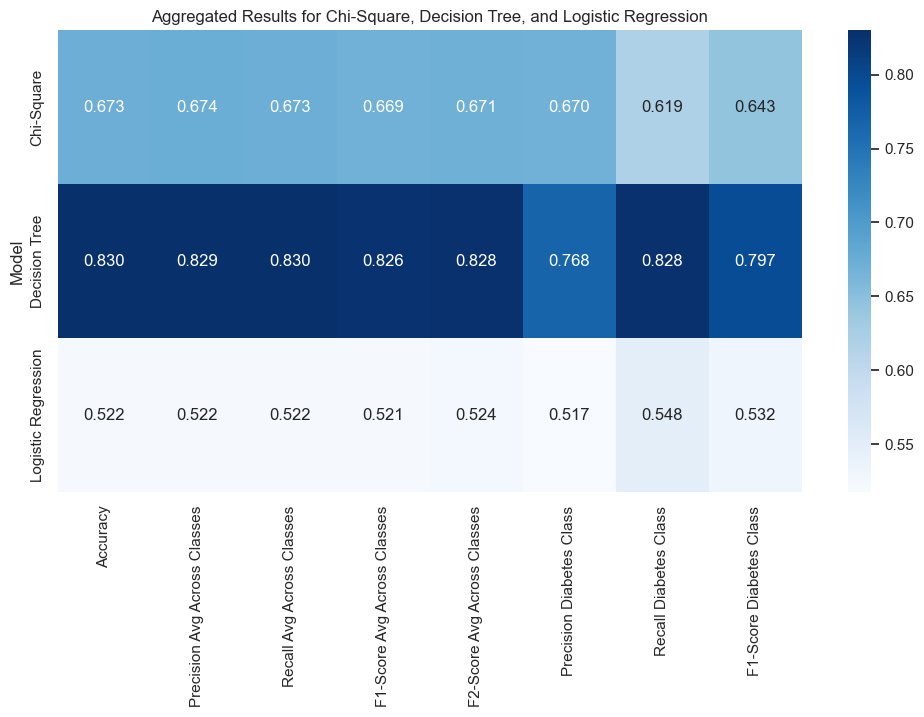

In [72]:
#Create aheatmap of the above results 
plt.figure(figsize=(12, 6))
sns.heatmap(aggregated_results, annot=True, cmap='Blues', fmt='.3f')
plt.title('Aggregated Results for Chi-Square, Decision Tree, and Logistic Regression')
plt.show()


## Apply Cross Validation to Select the Best Hyperparameters for Generalization Performance, and Display Top 10 Selected Features

Note: There are no specific hyperparameters to tune within a Chi-Square method. This technique will therefore only be applied to Decision Tree and Multinomial Logistic Regression. 

### Select Hyperparameters for Decision Tree

In [15]:
# Define parameter grid for Decision Tree
dt_param_grid = {
    'max_depth': [5, 10, 15, 20, None],  # Depth of tree
    'min_samples_split': [2, 10, 20],  # Minimum samples to split
    'min_samples_leaf': [1, 2, 4]  # Minimum samples at a leaf node
}

# Initialize GridSearchCV using cross-validation for Decision Tree
dt_grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the data
dt_grid_search.fit(X_train, y_train)

# Get the best parameters
dt_best_params = dt_grid_search.best_params_
print("Best parameters for Decision Tree:", dt_best_params)



Best parameters for Decision Tree: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [16]:
# Train the final models with the best hyperparameters
final_dt_model = DecisionTreeClassifier(random_state=42, max_depth=None, min_samples_leaf=1, min_samples_split=2)
final_dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

### Select Hyperparameters for Multinomial Logistic Regression

In [17]:
# Define parameter grid for Logistic Regression
lr_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'penalty': ['l2']  # Regularization type (only 'l2' is supported for lbfgs, newton-cg, and saga)
}

# Initialize GridSearchCV using cross-validation for Logistic Regression
lr_grid_search = GridSearchCV(
    LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000),  # Use lbfgs solver because it supports multinomial logistic regression
    lr_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Fit the grid search to the data
lr_grid_search.fit(X_train, y_train)

# Get the best parameters
lr_best_params = lr_grid_search.best_params_
print("Best parameters for Logistic Regression:", lr_best_params)

c:\Users\steph\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best parameters for Logistic Regression: {'C': 0.01, 'penalty': 'l2'}


In [18]:
# Train the final models with the best hyperparameters
final_lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=0.01, penalty='l2')
final_lr_model.fit(X_train, y_train)

c:\Users\steph\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\steph\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.01, multi_class='multinomial')

## Evaluate Feature Importance on the Final Model and Display Top 10 Selected Features for Each Model

### Chi Square

In [19]:
#Evaluate feature importance and display top 10 for chi square
# Get the feature names
feature_names = X_train.columns

# Create a DataFrame with the feature names and their chi-square values
chi2_df = pd.DataFrame({'Feature': feature_names, 'Chi2': chi2_values_mean, 'P-Value': p_values_mean})

# Sort the DataFrame by chi-square values in descending order
chi2_df = chi2_df.sort_values(by='Chi2', ascending=False)

# Display the top 10 features
print("\nTop 10 Features based on Chi-Square Test Statistics:")
print(chi2_df.head(10))


Top 10 Features based on Chi-Square Test Statistics:
                 Feature          Chi2  P-Value
15              PhysHlth  15906.114097      0.0
18                   Age  12565.886623      0.0
10     HvyAlcoholConsump  10831.307774      0.0
0                 HighBP   8502.168700      0.0
13               GenHlth   7866.806445      0.0
20                Income   6894.925587      0.0
16              DiffWalk   6492.051992      0.0
6   HeartDiseaseorAttack   5301.555380      0.0
3                    BMI   4541.467313      0.0
1               HighChol   4439.846791      0.0


### Decision Tree 

In [20]:
#Evaluate feature importance of the final_dt_model and display the top 10 features
# Get feature importance from the final Decision Tree model
dt_feature_importance = final_dt_model.feature_importances_

# Get the top 10 features with the highest feature importance
top_features_dt = pd.Series(dt_feature_importance, index=X_train.columns).sort_values(ascending=False).head(10)

# Display the top 10 features with the highest feature importance
print("Top 10 Features with Highest Feature Importance (Decision Tree):")
print(top_features_dt)

Top 10 Features with Highest Feature Importance (Decision Tree):
Age             0.152948
Income          0.141196
Education       0.095062
BMI             0.085562
PhysHlth        0.073705
MentHlth        0.058286
GenHlth         0.053123
PhysActivity    0.041451
Fruits          0.038611
Veggies         0.037485
dtype: float64


### Multinomial Logistic Regression

In [21]:
# Get the feature names
feature_names = X_train.columns

# Get the coefficients of the logistic regression model
coefficients = final_lr_model.coef_[0]  # Coefficients for a binary classification (first row)

# Create a DataFrame to pair feature names with their coefficients
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Add a column for the absolute value of the coefficients
feature_importance_df['AbsCoefficient'] = feature_importance_df['Coefficient'].abs()

# Sort by absolute coefficient value in descending order
feature_importance_df_sorted = feature_importance_df.sort_values(by='AbsCoefficient', ascending=False)

# Display the sorted DataFrame
print(feature_importance_df_sorted[['Feature', 'Coefficient', 'AbsCoefficient']])

                 Feature  Coefficient  AbsCoefficient
10     HvyAlcoholConsump     1.559197        1.559197
5                 Stroke     0.815233        0.815233
12           NoDocbcCost     0.601515        0.601515
2              CholCheck    -0.416879        0.416879
11         AnyHealthcare     0.296866        0.296866
4                 Smoker     0.286085        0.286085
6   HeartDiseaseorAttack     0.281161        0.281161
16              DiffWalk     0.257799        0.257799
0                 HighBP    -0.249347        0.249347
1               HighChol    -0.245837        0.245837
13               GenHlth    -0.240768        0.240768
8                 Fruits     0.196570        0.196570
7           PhysActivity     0.194922        0.194922
3                    BMI    -0.154075        0.154075
17                   Sex     0.121109        0.121109
19             Education     0.120646        0.120646
9                Veggies     0.109324        0.109324
18                   Age    

### Visualize Feature Importance for Each Feature Selection Model

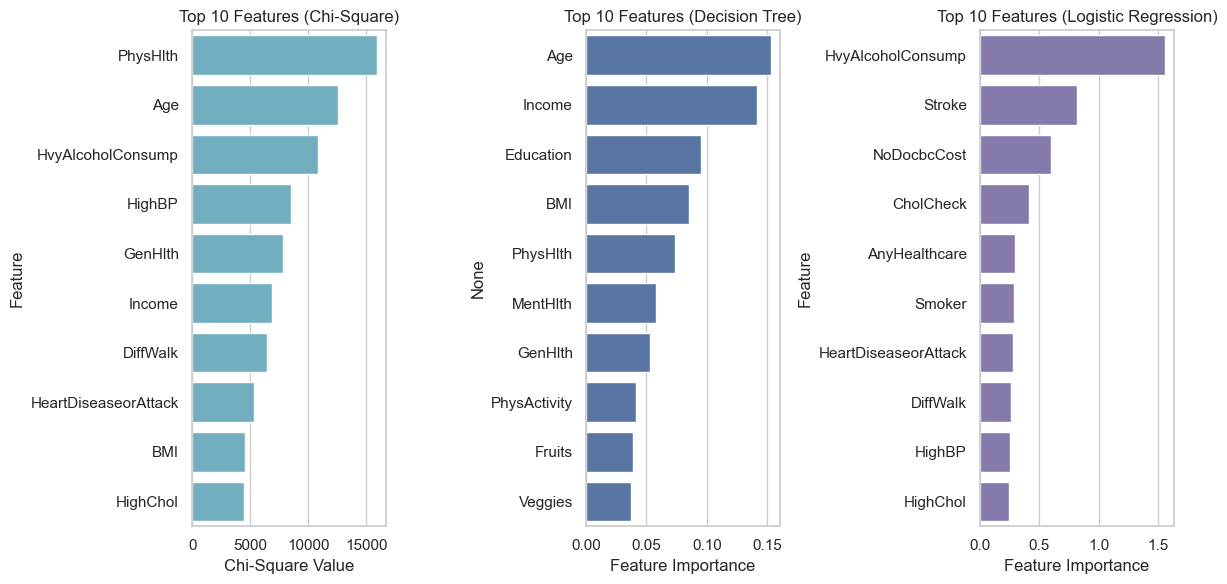

In [ ]:
#Visualize top 10 features with the highest feature importance for Chi Square, Decision Tree, and Logistic Regression

# Set the style of the visualization
sns.set(style="whitegrid")

# Initialize the matplotlib figure
plt.figure(figsize=(12, 6))

# Plot the top 10 features with the highest Chi-Square values
plt.subplot(1, 3, 1)
sns.barplot(x=chi2_df['Chi2'].head(10), y=chi2_df['Feature'].head(10), color='c')
plt.title("Top 10 Features (Chi-Square)")
plt.xlabel("Chi-Square Value")

# Plot the top 10 features with the highest feature importance for Decision Tree
plt.subplot(1, 3, 2)
sns.barplot(x=top_features_dt.values, y=top_features_dt.index, color='b')
plt.title("Top 10 Features (Decision Tree)")
plt.xlabel("Feature Importance")

# Plot the top 10 features with the highest feature importance for Logistic Regression
plt.subplot(1, 3, 3)
sns.barplot(x=feature_importance_df_sorted['AbsCoefficient'].head(10), y=feature_importance_df_sorted['Feature'].head(10), color='m')
plt.title("Top 10 Features (Logistic Regression)")
plt.xlabel("Feature Importance")

# Show the plot
plt.tight_layout()
plt.show()


## Train Final Models on Test Set to Assess Generalizability and Evaluate Performance Metrics:

### Chi Square

Specificities per class: [np.float64(0.6435150609907891), np.float64(0.8027770049824224), np.float64(0.7771471247199403)]
Macro-average specificity: 0.7411463968977173
Confusion Matrix of Decision Tree with Chi-Square on Test Set:
[[18971  6434  7085]
 [  375   235   375]
 [ 2489  1364  3196]]
Evaluation Metrics for Decision Tree with Chi-Square:
Accuracy: 0.5528082124173329
Precision: 0.39933789698321304
Recall: 0.42529302152116105
F1-Score: 0.3705240278106636
F2-Score: 0.3781102478900071
Specificity: 0.7411463968977173
Precision for Diabetes_012 = 2: 0.29992492492492495
Recall for Diabetes_012 = 2: 0.4533976450560363
F1-Score for Diabetes_012 = 2: 0.3610279582038972
Classification Report of Decision Tree with Chi-Square on Test Set:
              precision    recall  f1-score   support

           0       0.87      0.58      0.70     32490
           1       0.03      0.24      0.05       985
           2       0.30      0.45      0.36      7049

    accuracy                         

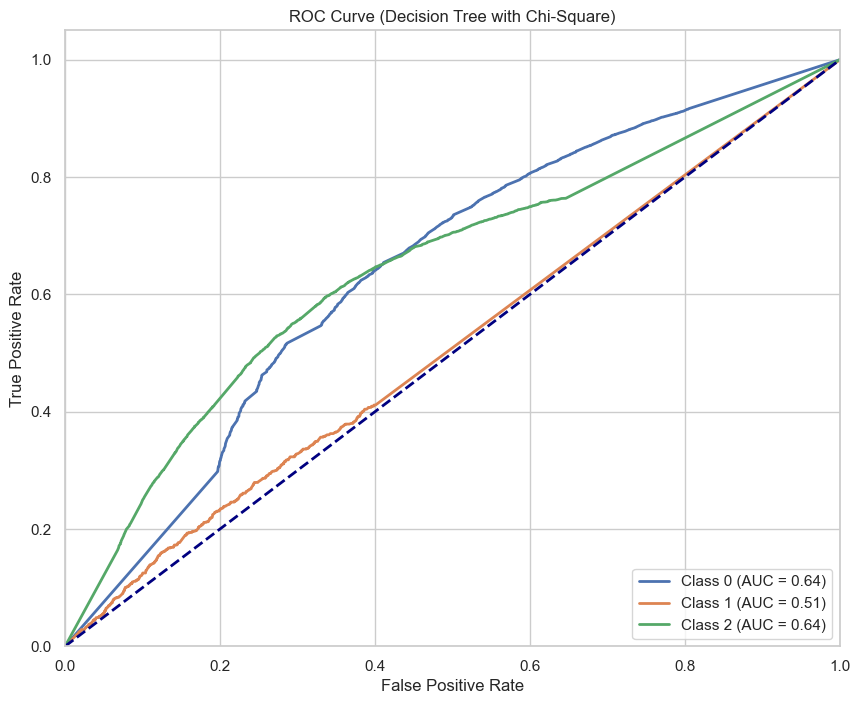

In [ ]:
# Apply Chi-Square on the training set
chi2_selector = SelectKBest(chi2, k=10)  # You can adjust the 'k' value
X_train_chi2 = chi2_selector.fit_transform(X_train, y_train)

# Get the top 10 features
chi2_features = X_train.columns[chi2_selector.get_support()]


# Transform the test set based on the training set's feature selection
X_test_chi2 = chi2_selector.transform(X_test)

# Initialize the Decision Tree model
chi2_model = DecisionTreeClassifier(random_state=42)
chi2_model.fit(X_train_chi2, y_train)

# Predict the target variable on the test set
chi2_y_pred = chi2_model.predict(X_test_chi2)

# Compute Evaluation Metrics
chi2_accuracy = accuracy_score(y_test, chi2_y_pred)
chi2_precision = precision_score(y_test, chi2_y_pred, average='macro')
chi2_recall = recall_score(y_test, chi2_y_pred, average='macro')
chi2_f1_score = f1_score(y_test, chi2_y_pred, average='macro')
chi2_f2_score = fbeta_score(y_test, chi2_y_pred, average='macro', beta=2)
#precision, recall and f1 score for diabetes_012 = 2
chi2_precision_diabetes_012_2 = precision_score(y_test, chi2_y_pred, average=None)[2]
chi2_recall_diabetes_012_2 = recall_score(y_test, chi2_y_pred, average=None)[2]
chi2_f1_score_diabetes_012_2 = f1_score(y_test, chi2_y_pred, average=None)[2]


#Compute Specificity
# Compute the confusion matrix
chi2_conf_matrix = confusion_matrix(y_test, chi2_y_pred)

# Number of classes (based on confusion matrix)
n_classes = chi2_conf_matrix.shape[0]

# Initialize an array to store specificity for each class
specificities = []

# Compute specificity for each class
for i in range(n_classes):
    # True Negatives: all elements except the current class row and column
    TN = np.sum(np.delete(np.delete(chi2_conf_matrix, i, axis=0), i, axis=1))
    
    # False Positives: sum of the column corresponding to class i, excluding the diagonal element
    FP = np.sum(chi2_conf_matrix[:, i]) - chi2_conf_matrix[i, i]
    
    # Specificity for class i
    specificity_i = TN / (TN + FP)
    specificities.append(specificity_i)

# Compute the macro-average specificity (average across all classes)
chi2_specificity = np.mean(specificities)

# Calculate macro-average specificity (mean of all class-specific specificities)
macro_specificity = sum(specificities) / len(specificities)

# Output the results
print(f"Specificities per class: {specificities}")
print(f"Macro-average specificity: {macro_specificity}")

# Get the confusion matrix on the test set
print("Confusion Matrix of Decision Tree with Chi-Square on Test Set:")
print(confusion_matrix(y_test, chi2_y_pred))

#Display the evaluation metrics
print("Evaluation Metrics for Decision Tree with Chi-Square:")
print(f"Accuracy: {chi2_accuracy}")
print(f"Precision: {chi2_precision}")
print(f"Recall: {chi2_recall}")
print(f"F1-Score: {chi2_f1_score}")
print(f"F2-Score: {chi2_f2_score}")
print(f"Specificity: {chi2_specificity}")
print(f"Precision for Diabetes_012 = 2: {chi2_precision_diabetes_012_2}")
print(f"Recall for Diabetes_012 = 2: {chi2_recall_diabetes_012_2}")
print(f"F1-Score for Diabetes_012 = 2: {chi2_f1_score_diabetes_012_2}")

# Get the classification report on the test set
print("Classification Report of Decision Tree with Chi-Square on Test Set:")
print(classification_report(y_test, chi2_y_pred))

# Get the predicted probabilities for the test set
chi2_y_pred_proba = chi2_model.predict_proba(X_test_chi2)

# Binarize the true labels for multiclass ROC curve calculation
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Compute ROC AUC score using One-vs-Rest (OvR) approach
chi2_roc_auc = roc_auc_score(y_test_bin, chi2_y_pred_proba, multi_class='ovr')
print("ROC AUC of Decision Tree with Chi-Square on Test Set:", chi2_roc_auc)

# Compute the ROC curve for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(y_test_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], chi2_y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve
plt.figure(figsize=(10, 8))
for i in range(y_test_bin.shape[1]):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:0.2f})')

# Plot diagonal (chance level)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Decision Tree with Chi-Square)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Compute the Chi-Square values for the test set
chi2_values = chi2_selector.scores_
p_values = chi2_selector.pvalues_

# Create a DataFrame with the feature names and their Chi-Square values
chi2_test_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Chi2': chi2_values,
    'P-Value': p_values
})

# Sort the DataFrame by Chi-Square values in descending order
chi2_test_df = chi2_test_df.sort_values(by='Chi2', ascending=False)

# Display the top 10 features with the highest Chi-Square values
print("Top 10 Features based on Chi-Square Test Statistics (Test Set):")
print(chi2_test_df.head(10))

Top 10 Features based on Chi-Square Test Statistics (Test Set):
                 Feature          Chi2  P-Value
15              PhysHlth  19880.205035      0.0
18                   Age  15706.865818      0.0
10     HvyAlcoholConsump  13538.843130      0.0
0                 HighBP  10627.534037      0.0
13               GenHlth   9833.419556      0.0
20                Income   8618.220826      0.0
16              DiffWalk   8114.870709      0.0
6   HeartDiseaseorAttack   6626.588607      0.0
3                    BMI   5676.600259      0.0
1               HighChol   5549.564829      0.0


### Decision Tree

Confusion Matrix (Decision Tree):
[[22734  2237  7519]
 [  572    89   324]
 [ 3744   569  2736]]

Evaluation Metrics (Decision Tree):
Accuracy: 0.6307126641002863
Precision: 0.3766039538853134
Recall: 0.39273949445468553
F1-Score: 0.37331540768452265
F2-Score: 0.38062578006190306
Macro-average Specificity: 0.7191736723249349
Precision for Diabetes_012 = 2: 0.258625578977219
Recall for Diabetes_012 = 2: 0.3881401617250674
F1-Score for Diabetes_012 = 2: 0.31041524846834584


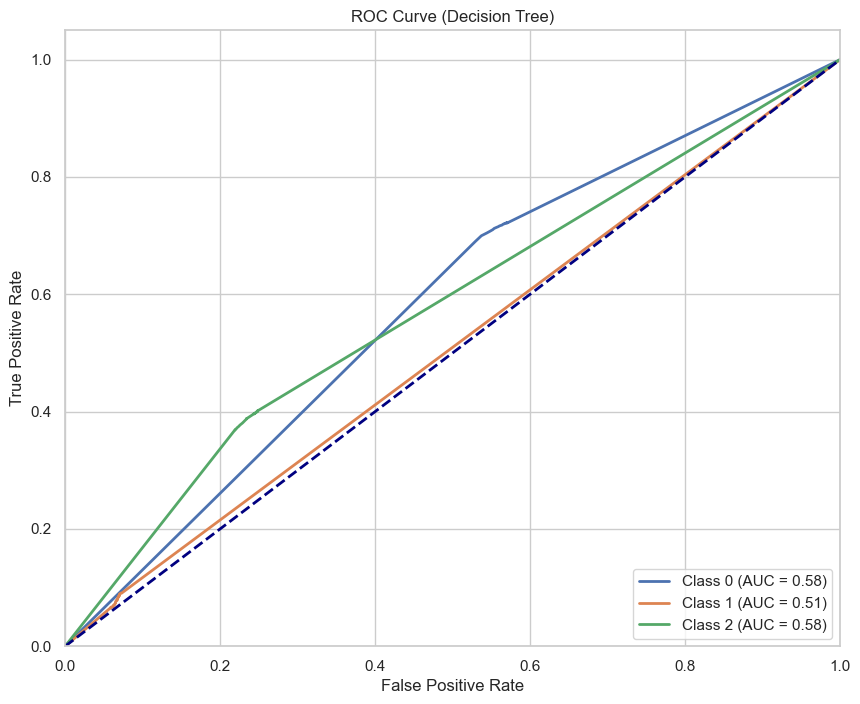

In [53]:
# Predict using the final Decision Tree model
dt_pred_test = final_dt_model.predict(X_test)

# Compute the confusion matrix
dt_conf_matrix = confusion_matrix(y_test, dt_pred_test)

# Compute evaluation metrics
dt_accuracy = accuracy_score(y_test, dt_pred_test)
dt_precision = precision_score(y_test, dt_pred_test, average='macro')
dt_recall = recall_score(y_test, dt_pred_test, average='macro')
dt_f1 = f1_score(y_test, dt_pred_test, average='macro')
dt_f2 = fbeta_score(y_test, dt_pred_test, average='macro', beta=2)
#precision, recall and f1 score for diabetes_012 = 2
dt_precision_diabetes_012_2 = precision_score(y_test, dt_pred_test, average=None)[2]
dt_recall_diabetes_012_2 = recall_score(y_test, dt_pred_test, average=None)[2]
dt_f1_diabetes_012_2 = f1_score(y_test, dt_pred_test, average=None)[2]


# Compute overall specificity
# Number of classes (based on confusion matrix)
n_classes = dt_conf_matrix.shape[0]

# Initialize an array to store specificity for each class
specificities = []

# Compute specificity for each class
for i in range(n_classes):
    # True Negatives: all elements except the current class row and column
    TN = np.sum(np.delete(np.delete(dt_conf_matrix, i, axis=0), i, axis=1))
    
    # False Positives: sum of the column corresponding to class i, excluding the diagonal element
    FP = np.sum(dt_conf_matrix[:, i]) - dt_conf_matrix[i, i]
    
    # Specificity for class i
    specificity_i = TN / (TN + FP)
    specificities.append(specificity_i)

# Compute the macro-average specificity (average across all classes)
dt_specificity = np.mean(specificities)

# Display the confusion matrix
print("Confusion Matrix (Decision Tree):")
print(dt_conf_matrix)

# Display the evaluation metrics
print("\nEvaluation Metrics (Decision Tree):")
print(f"Accuracy: {dt_accuracy}")
print(f"Precision: {dt_precision}")
print(f"Recall: {dt_recall}")
print(f"F1-Score: {dt_f1}")
print(f"F2-Score: {dt_f2}")
print(f"Macro-average Specificity: {dt_specificity}") 
print(f"Precision for Diabetes_012 = 2: {dt_precision_diabetes_012_2}")
print(f"Recall for Diabetes_012 = 2: {dt_recall_diabetes_012_2}")
print(f"F1-Score for Diabetes_012 = 2: {dt_f1_diabetes_012_2}")

# Compute ROC curve and AUC for Decision Tree
# Binarize the true labels for multiclass classification
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Get the predicted probabilities for each class
dt_probs = final_dt_model.predict_proba(X_test)

# Compute ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(y_test_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], dt_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve
plt.figure(figsize=(10, 8))
for i in range(y_test_bin.shape[1]):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:0.2f})')

# Plot diagonal (chance level)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Decision Tree)')
plt.legend(loc="lower right")
plt.show()


### Multinomial Logistic Regression


Confusion Matrix (Logistic Regression):
[[18440  7261  6789]
 [  315   236   434]
 [ 1588  1273  4188]]

Evaluation Metrics (Logistic Regression):
Accuracy: 0.564208863883131
Precision: 0.4334595044173948
Recall: 0.46709332804311554
F1-Score: 0.40005727432547866
F2-Score: 0.4116540829914488
Specificity: 0.7191736723249349
Precision for Diabetes_012 = 2: 0.3670142844623609
Recall for Diabetes_012 = 2: 0.5941268265002128
F1-Score for Diabetes_012 = 2: 0.4537378114842904


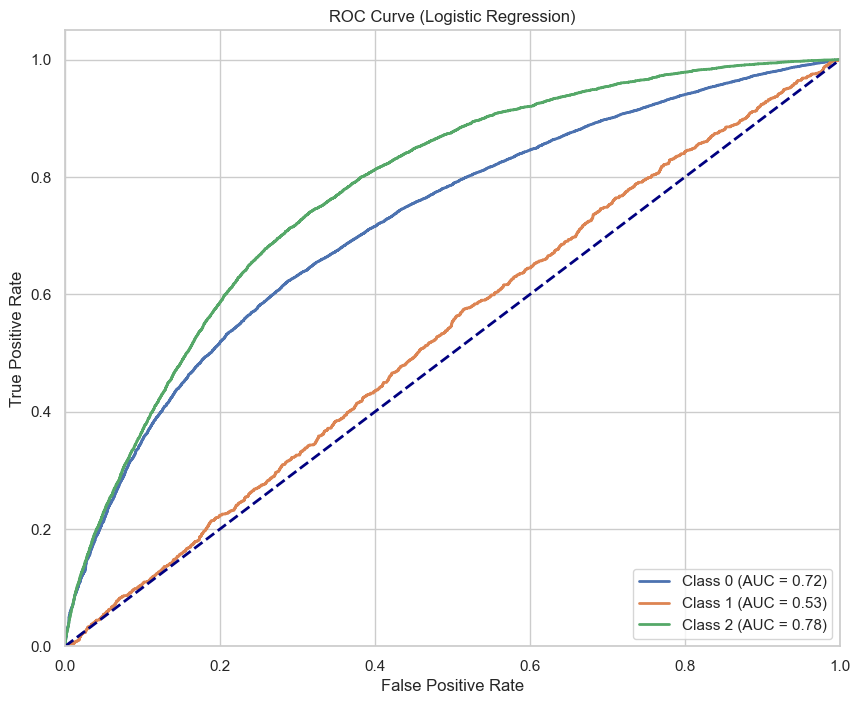

In [54]:
# Predict using the final Logistic Regression model
lr_pred_test = final_lr_model.predict(X_test)

# Compute the confusion matrix
lr_conf_matrix = confusion_matrix(y_test, lr_pred_test)

# Compute evaluation metrics
lr_accuracy = accuracy_score(y_test, lr_pred_test)
lr_precision = precision_score(y_test, lr_pred_test, average='macro')
lr_recall = recall_score(y_test, lr_pred_test, average='macro')
lr_f1 = f1_score(y_test, lr_pred_test, average='macro')
lr_f2 = fbeta_score(y_test, lr_pred_test, average='macro', beta=2)
#precision, recall and f1 score for diabetes_012 = 2
lr_precision_diabetes_012_2 = precision_score(y_test, lr_pred_test, average=None)[2]
lr_recall_diabetes_012_2 = recall_score(y_test, lr_pred_test, average=None)[2]
lr_f1_diabetes_012_2 = f1_score(y_test, lr_pred_test, average=None)[2]

# Compute overall specificity
# Number of classes (based on confusion matrix)
n_classes = dt_conf_matrix.shape[0]

# Initialize an array to store specificity for each class
specificities = []

# Compute specificity for each class
for i in range(n_classes):
    # True Negatives: all elements except the current class row and column
    TN = np.sum(np.delete(np.delete(dt_conf_matrix, i, axis=0), i, axis=1))
    
    # False Positives: sum of the column corresponding to class i, excluding the diagonal element
    FP = np.sum(dt_conf_matrix[:, i]) - dt_conf_matrix[i, i]
    
    # Specificity for class i
    specificity_i = TN / (TN + FP)
    specificities.append(specificity_i)

# Compute the macro-average specificity (average across all classes)
lr_specificity = np.mean(specificities)

# Display the confusion matrix
print("\nConfusion Matrix (Logistic Regression):")
print(lr_conf_matrix)

# Display the evaluation metrics
print("\nEvaluation Metrics (Logistic Regression):")
print(f"Accuracy: {lr_accuracy}")
print(f"Precision: {lr_precision}")
print(f"Recall: {lr_recall}")
print(f"F1-Score: {lr_f1}")
print(f"F2-Score: {lr_f2}")
print(f"Specificity: {lr_specificity}")
print(f"Precision for Diabetes_012 = 2: {lr_precision_diabetes_012_2}")
print(f"Recall for Diabetes_012 = 2: {lr_recall_diabetes_012_2}")
print(f"F1-Score for Diabetes_012 = 2: {lr_f1_diabetes_012_2}")

# Binarize the true labels for multiclass classification
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Get the predicted probabilities for each class
lr_probs = final_lr_model.predict_proba(X_test)

# Compute ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(y_test_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], lr_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve
plt.figure(figsize=(10, 8))
for i in range(y_test_bin.shape[1]):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:0.2f})')

# Plot diagonal (chance level)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Logistic Regression)')
plt.legend(loc="lower right")
plt.show()

### Visualize Evaluation Metrics for Each Technique

In [55]:
# Visualize the evaluation metrics for Chi Square, Decision Tree, and Logistic Regression
# Define the evaluation metrics
metrics = ['Accuracy', 'Precision Avg Across Classes', 'Recall Avg Across Classes', 'F1-Score Avg Across Classes', 'F2-Score Avg Across Classes', 'Precision Diabetes Class', 'Recall Diabetes Class', 'F1-Score Diabetes Class', 'Specificity', 'ROC AUC']

# Define the evaluation metrics for Chi-Square, Decision Tree, and Logistic Regression
# Ensure there are exactly 9 metrics for each model
chi2_metrics = [chi2_accuracy, chi2_precision, chi2_recall, chi2_f1_score, chi2_f2_score, chi2_precision_diabetes_012_2, chi2_recall_diabetes_012_2, chi2_f1_score_diabetes_012_2, chi2_specificity, chi2_roc_auc]
dt_metrics = [dt_accuracy, dt_precision, dt_recall, dt_f1, dt_f2, dt_precision_diabetes_012_2, dt_recall_diabetes_012_2, dt_f1_diabetes_012_2, dt_specificity, roc_auc_score(y_test_bin, dt_probs, multi_class='ovr')]
lr_metrics = [lr_accuracy, lr_precision, lr_recall, lr_f1, lr_f2, lr_precision_diabetes_012_2, lr_recall_diabetes_012_2, lr_f1_diabetes_012_2, lr_specificity, roc_auc_score(y_test_bin, lr_probs, multi_class='ovr')]

# Create a DataFrame with the evaluation metrics
metrics_df = pd.DataFrame({
    'Metrics': metrics,
    'Chi-Square': chi2_metrics,
    'Decision Tree': dt_metrics,
    'Logistic Regression': lr_metrics
})

# Display the evaluation metrics
display(metrics_df)

,Metrics,Chi-Square,Decision Tree,Logistic Regression
0,Accuracy,0.552808,0.630713,0.564209
1,Precision Avg Across Classes,0.399338,0.376604,0.433460
2,Recall Avg Across Classes,0.425293,0.392739,0.467093
3,F1-Score Avg Across Classes,0.370524,0.373315,0.400057
4,F2-Score Avg Across Classes,0.378110,0.380626,0.411654
5,Precision Diabetes Class,0.299925,0.258626,0.367014
6,Recall Diabetes Class,0.453398,0.388140,0.594127
7,F1-Score Diabetes Class,0.361028,0.310415,0.453738
8,Specificity,0.741146,0.719174,0.719174
9,ROC AUC,0.599513,0.556101,0.676085


Summary of Findings: It was identified that the best performing Feature selection method is Multinomial Logistic Regression because it has the highest precision, recall , F1 and F2 score, as well as highly outperforms the other two models with a high sensitivity of 0.7 making it the best model for detecting diabetes and minimizing false negatives (or mimssing a diabetes diagnosis). 



The Decision tree has the highest accuracy indicating that it is the model able to correctly predict positive and negative cases 63% of the time. Logistic Regression has the highest precision indicating that it is more accurate when predicting positive diabetes cases, reducing the risk of false alarms. Logistic regression also had the highest recall/sensitivity, making it the best model for ensuring we don't miss any diabetes diagnosis. Logistic also had the highest F1  showing it good balance between precision and recall. It also has the highest F2 score (which puts more emphasis on recall) indicating that it is a good model for identifying as many true positive diabetes cases. Logistic regression outperforms chi-square and decision when it comes to the sensitivity of the model (72%), further emphasizing it is the best model for catching as many positive cases as possible when looking not to miss any diagnosis.  Specificity identifies how well the model identifies true negatives. Lastly, Logistic regression also had the highest ROC AUC (0.67154) meaning it is the most effective model at distinguishing between the classes. 

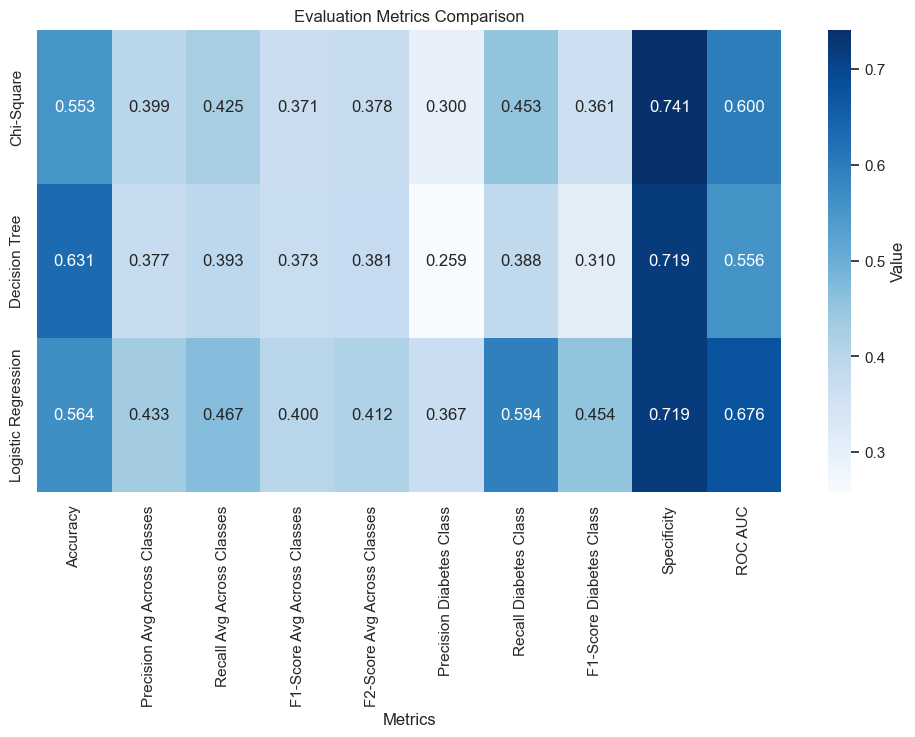

In [56]:
#ceate a heat map to visualize the evaluation metrics for each model
# Set the style of the visualization
sns.set(style="whitegrid")

# Initialize the matplotlib figure
plt.figure(figsize=(12, 6))

# Plot the heatmap
sns.heatmap(metrics_df.set_index('Metrics').T, annot=True, cmap='Blues', fmt='.3f', cbar_kws={'label': 'Value'})
plt.title("Evaluation Metrics Comparison")
plt.show()



Text(0.5, 1.0, 'Test Set Final Model')

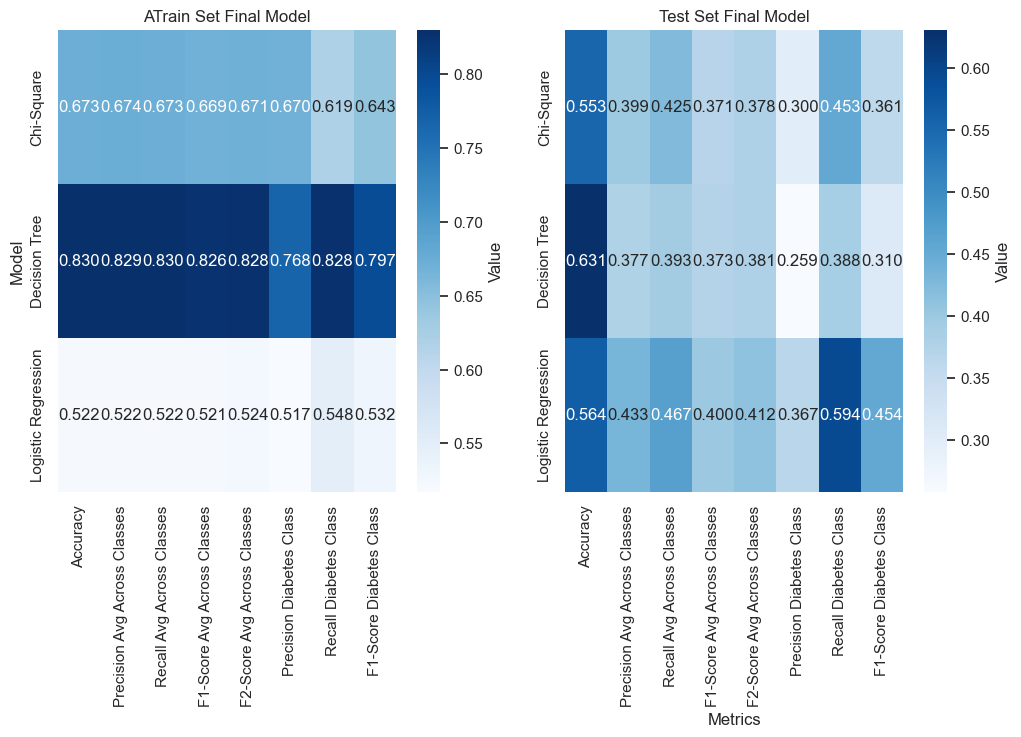

In [76]:
#drop metrics_df Specificity and Roc Auc rows 
metrics_df = metrics_df[metrics_df.Metrics != 'Specificity']
metrics_df = metrics_df[metrics_df.Metrics != 'ROC AUC']

# Create a chart to compare aggregated_results and metrics_df
# Set the style of the visualization
sns.set(style="whitegrid")

# Initialize the matplotlib figure
plt.figure(figsize=(12, 6))

# Plot the aggregated results and evaluation metrics
plt.subplot(1, 2, 1)
sns.heatmap(aggregated_results, annot=True, cmap='Blues', fmt='.3f', cbar_kws={'label': 'Value'})
plt.title("ATrain Set Final Model")

plt.subplot(1, 2, 2)
sns.heatmap(metrics_df.set_index('Metrics').T, annot=True, cmap='Blues', fmt='.3f', cbar_kws={'label': 'Value'})
plt.title("Test Set Final Model")



In [99]:
#Display top ten features  features selected by Chi-Square and Decision Tree and logistic models on test set

# Get the top 10 features with the highest feature importance for Decision Tree
dt_feature_importance = final_dt_model.feature_importances_
top_features_dt = pd.Series(dt_feature_importance, index=X_train.columns).sort_values(ascending=False).head(10)

# Get the feature names selected by Logistic Regression
lr_coefficients = final_lr_model.coef_[0]
top_features_lr = pd.Series(lr_coefficients, index=X_train.columns).abs().sort_values(ascending=False).head(10)

# Create a DataFrame to store the top 10 features for each model
top_features_df = pd.DataFrame({
    'Chi-Square': chi2_df.head(10)['Feature'],
    'Decision Tree': top_features_dt.index,
    'Logistic Regression': top_features_lr.index
})

# Display the top 10 features for each model
display(top_features_df)



,Chi-Square,Decision Tree,Logistic Regression
15,PhysHlth,Age,HvyAlcoholConsump
18,Age,Income,Stroke
10,HvyAlcoholConsump,Education,NoDocbcCost
0,HighBP,BMI,CholCheck
13,GenHlth,PhysHlth,AnyHealthcare
20,Income,MentHlth,Smoker
16,DiffWalk,GenHlth,HeartDiseaseorAttack
6,HeartDiseaseorAttack,PhysActivity,DiffWalk
3,BMI,Fruits,HighBP
1,HighChol,Veggies,HighChol
